In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [5]:
!cp ../mcmc_py/pd_model.py .
from pd_model import *

In [6]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)


In [5]:
def plot_matrix(frame, **args):
    from matplotlib.colors import LogNorm
    x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    (lambda x: xlim(x[0],x[-1]))(frame.columns)
    (lambda x: ylim(x[0],x[-1]))(frame.index  ) 
    return ret

#Make binnings

In [6]:
#
# "Theoretical" binning (the one we will look the spectrum for)
#  is bootstrapped from R-vs-beta curves for D and P 
#
def make_beta_bins(beta):
    bbins = []
    for i in range(10):
        bbins.append(beta)
        beta = beta_from_R(R_from_beta(beta,md),mp)
    return bbins

bbins = make_beta_bins(0.5)
bbins += make_beta_bins((bbins[1]+bbins[0])/2)
bbins = sorted(bbins)

mid1,mid2 = (bbins[1]+bbins[0])/2,(bbins[2]+bbins[1])/2
bbins += make_beta_bins(mid1)
bbins += make_beta_bins(mid2)
bbins = np.array(sorted(bbins))

betaTheoretic, rgdtTheoretic = np.array([bbins, R_from_beta(bbins, mp)])

In [ ]:
rcParams['savefig.dpi'] = 160
figsize(8,4)
for b in betaTheoretic:plot([0,10],[b,b],'k',lw=0.5)
for R in rgdtTheoretic:plot([R,R], [0.5,1],'k',lw=0.5)
xlabel("R theoretic")
ylabel("$\\beta$ theoretic")
xlim(rgdtTheoretic[0],10)
ylim(0.49,1)

x = np.linspace(0,10,100)
plot(x, beta_from_R(x,mp),'r')
plot(x, beta_from_R(x,md),'b')

In [7]:
#
# Measured values binnings are not very fancy
#
betaMeasured = 1/np.linspace(0.5,2,28)
betaMeasured.sort()

rgdtMeasured = np.logspace(-5.0 / 19, 1, 25)

In [ ]:
rcParams['savefig.dpi'] = 160
figsize(8,4)
for b in betaMeasured:plot([0,10],[b,b],'k',lw=0.5)
for R in rgdtMeasured:plot([R,R], [0.5,1.2],'k',lw=0.5)
xlabel("R measured")
ylabel("$\\beta$ measured")
xlim(rgdtTheoretic[0],10)
ylim(0.49,1.21)

x = np.linspace(0,10,100)
plot(x, beta_from_R(x,mp),'r')
plot(x, beta_from_R(x,md),'b')

# Making BQ clear

In [8]:
import bq
from histQueryFactory import *
client = bq.Client.Get()

/afs/cern.ch/user/k/kostams/Virualenv/ipython/lib/python2.7/site-packages/Crypto/Util/number.py:57: PowmInsecureWarning: Not using mpz_powm_sec.  You should rebuild using libgmp >= 5 to avoid timing attack vulnerability.
  _warn("Not using mpz_powm_sec.  You should rebuild using libgmp >= 5 to avoid timing attack vulnerability.", PowmInsecureWarning)


In [9]:
schema = client.GetTableSchema({
    'projectId': 'ams-test-kostya', 
    'datasetId': 'AMS',  
    'tableId': 'protonsB1034'
})

bitFields = None
for field in schema['fields']:
    if field['name'] != 'selStatus': 
        continue
    bitFields = field['description'].split(',')
    break
    
get_cumulative_mask = lambda sel: (1 << (bitFields.index(sel))) - 1

In [11]:
import itertools
def iterpairs(l):
    i1,i2 = itertools.tee(l); next(i2)
    return((x1,x2) for x1,x2 in itertools.izip(i1,i2))

def build_case_string(var, name, bins):
    casestr = ["CASE"]
    casestr += ["  WHEN {1} < {0} AND {0} < {2} THEN {3}".format(var,s,e,n)
                 for n,(s,e)  in enumerate(iterpairs(bins))]
    casestr += ["  ELSE -1",  "END as {0}".format(name)]
    return '\n'.join(casestr)

# Beta matrix

In [12]:
vs =  ",\n".join([ build_case_string("BetaTOF", "B_bin", betaMeasured),
                   build_case_string("GenMomentum/SQRT(0.88022 + POW(GenMomentum,2))", "Gen_bin", betaTheoretic),
                   "COUNT(1) as count" ])

h = "SELECT\n" + vs + """
FROM
   AMS.protonsB1034
WHERE
   selStatus&2097151=2097151
GROUP BY B_bin,Gen_bin
ORDER BY B_bin,Gen_bin"""

tableid = client.Query(str(h))['configuration']['query']['destinationTable']
bq_table = client.ReadTableRows(tableid)

Waiting on bqjob_r699489ddf13f72c0_0000014e20c57765_1 ... (0s) Current status: DONE   


In [13]:
frame = pd.DataFrame(bq_table, columns=['Bbin', 'GenBin', 'Count']).astype(int)
frame['Bbin'] = frame['Bbin'].map(lambda x: betaMeasured[x] )
frame['GenBin'] = frame['GenBin'].map(lambda x: betaTheoretic[x] )
frame = frame.set_index(list(frame.columns[:-1])).unstack()['Count'].fillna(0)

In [14]:
frame.T.to_csv("./datasets/B_resolution.csv")

(0.6, 1.4)

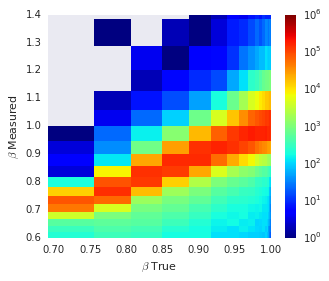

In [15]:
figsize(5,4)
cc = plot_matrix(frame.ix[frame.index[:-1]][frame.columns[:-1]],
           norm=LogNorm(vmin=1,vmax=10**6))
colorbar(cc)
xlabel("$\\beta$ True")
ylabel("$\\beta$ Measured")
ylim(0.6,1.4)

# Rigidity matrix

In [16]:
vs =  ",\n".join([ build_case_string("R", "R_bin", rgdtMeasured),
                   build_case_string("GenMomentum", "Gen_bin", rgdtTheoretic),
                   "COUNT(1) as count" ])

h = "SELECT\n" + vs + """
FROM
   AMS.protonsB1034
WHERE
   selStatus&2097151=2097151
GROUP BY R_bin,Gen_bin
ORDER BY R_bin,Gen_bin"""

tableid = client.Query(str(h))['configuration']['query']['destinationTable']
bq_table = client.ReadTableRows(tableid)

Waiting on bqjob_r292806ff37cd635e_0000014e20c5ba90_2 ... (0s) Current status: DONE   


In [17]:
frame = pd.DataFrame(bq_table, columns=['Rbin', 'GenBin', 'Count']).astype(int)
frame['Rbin'] = frame['Rbin'].map(lambda x: rgdtMeasured[x] )
frame['GenBin'] = frame['GenBin'].map(lambda x: rgdtTheoretic[x] )
frame = frame.set_index(list(frame.columns[:-1])).unstack()['Count'].fillna(0)

In [18]:
frame.T.to_csv("./datasets/R_resolution.csv")

(0.5, 10)

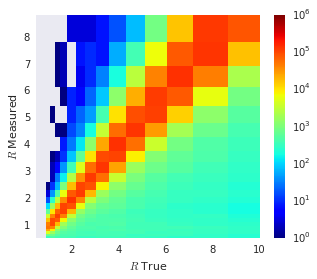

In [19]:
figsize(5,4)
cc = plot_matrix(frame.ix[frame.index[:-1]][frame.columns[:-1]],
           norm=LogNorm(vmin=1,vmax=10**6))
colorbar(cc)
xlabel("$R$ True")
ylabel("$R$ Measured")
xlim(0.5,10)

#Target

In [45]:
vs =  ",\n".join([ build_case_string("R", "R_bin", rgdtMeasured),
                   build_case_string("BetaTOF", "B_bin", betaMeasured),
                   "COUNT(1) as count" ])

h = "SELECT\n" + vs + """
FROM
   AMS.Data
WHERE
   selStatus&2097151=2097151 AND
   Livetime > 0.5 AND
   ABS(Latitude) > 1.0
GROUP BY R_bin,B_bin
ORDER BY R_bin,B_bin"""
tableid = client.Query(str(h))['configuration']['query']['destinationTable']
bq_table = client.ReadTableRows(tableid)

Waiting on bqjob_rb8cea54ece4606_0000014e20d9caa4_7 ... (0s) Current status: DONE   


In [46]:
frame = pd.DataFrame(bq_table, columns=['Rbin', 'Beta', 'Count']).astype(int)
frame['Rbin'] = frame['Rbin'].map(lambda x: rgdtMeasured[x] )
frame['Beta'] = frame['Beta'].map(lambda x: betaMeasured[x] )
frame = frame.set_index(list(frame.columns[:-1])).unstack()['Count'].fillna(0)
frame = frame.T

(0.5, 1.3)

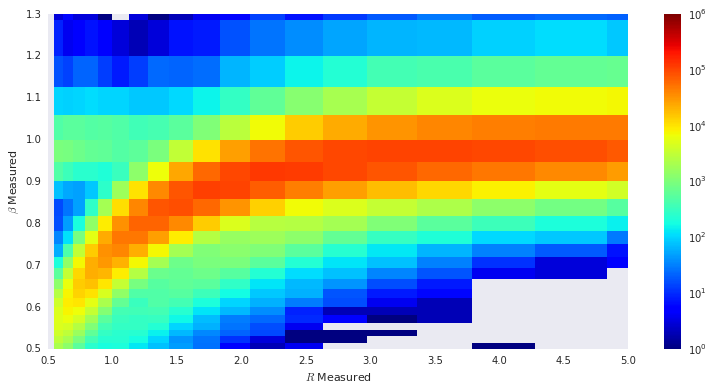

In [47]:
figsize(13,6)
cc = plot_matrix(frame.ix[frame.index[:-1]][frame.columns[:-1]],
           norm=LogNorm(vmin=1,vmax=10**6))
colorbar(cc)
xlabel("$R$ Measured")
ylabel("$\\beta$ Measured")
xlim(0.5,5)
ylim(0.5,1.3)

In [50]:
np.savetxt("datasets/observed_data.txt",frame.values)